# Dimensionality Reduction (Simple Guide)

Quick, hands-on overview of dimensionality reduction:
- Feature selection: keep the most useful original features
- Feature extraction: create new, compact features (components)

We'll cover VarianceThreshold, SelectKBest, PCA, LDA, and Kernel PCA with small examples.


In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

np.random.seed(42)


## Create a Simple Dataset
We'll use a synthetic classification dataset with redundant/noisy features to demonstrate selection and extraction.


In [2]:
# 2 informative, 2 redundant, 36 noise features
X, y = make_classification(
    n_samples=800,
    n_features=40,
    n_informative=2,
    n_redundant=2,
    n_repeated=0,
    n_classes=2,
    flip_y=0.02,
    class_sep=1.5,
    random_state=42,
)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"X shape: {X.shape}")


X shape: (800, 40)


## Part 1: Feature Selection
Feature selection keeps a subset of the original features.
- VarianceThreshold: drops features with low variance (little change)
- SelectKBest (ANOVA F-test): keeps top K features most related to the target


In [3]:
# VarianceThreshold (remove near-constant features)
vt = VarianceThreshold(threshold=0.01)
X_vt = vt.fit_transform(X_scaled)
print(f"After VarianceThreshold: {X_vt.shape}")

# SelectKBest (ANOVA F-test)
skb = SelectKBest(score_func=f_classif, k=10)
X_skb = skb.fit_transform(X_scaled, y)
print(f"After SelectKBest (k=10): {X_skb.shape}")


After VarianceThreshold: (800, 40)
After SelectKBest (k=10): (800, 10)


## Part 2: Feature Extraction
Feature extraction creates new features (components) from combinations of original features.
- PCA: finds directions of maximum variance (unsupervised)
- LDA: finds directions that best separate classes (supervised)
- Kernel PCA: non-linear PCA using kernels (e.g., RBF)


PCA explained variance ratio: [0.076 0.035]


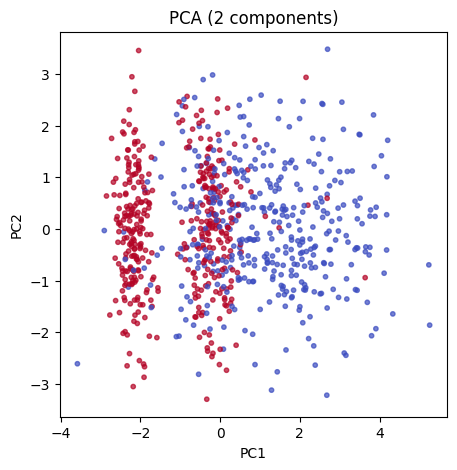

In [4]:
# PCA to 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print("PCA explained variance ratio:", np.round(pca.explained_variance_ratio_, 3))

plt.figure(figsize=(5, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=10, cmap='coolwarm', alpha=0.7)
plt.title('PCA (2 components)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


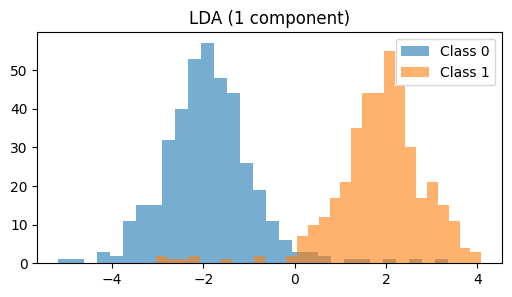

In [5]:
# LDA to 1D (for 2 classes, max components = n_classes - 1 = 1)
lda = LDA(n_components=1)
X_lda = lda.fit_transform(X_scaled, y)

plt.figure(figsize=(6, 3))
plt.hist(X_lda[y==0], bins=30, alpha=0.6, label='Class 0')
plt.hist(X_lda[y==1], bins=30, alpha=0.6, label='Class 1')
plt.title('LDA (1 component)')
plt.legend()
plt.show()


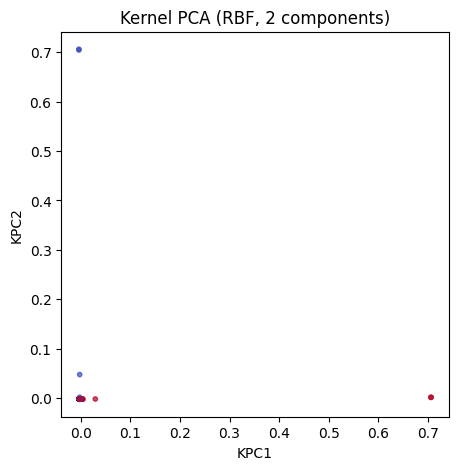

In [6]:
# Kernel PCA (RBF) to 2D
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=0.5, random_state=42)
X_kpca = kpca.fit_transform(X_scaled)

plt.figure(figsize=(5, 5))
plt.scatter(X_kpca[:, 0], X_kpca[:, 1], c=y, s=10, cmap='coolwarm', alpha=0.7)
plt.title('Kernel PCA (RBF, 2 components)')
plt.xlabel('KPC1')
plt.ylabel('KPC2')
plt.show()


## Quick Model Check (Optional)
Let's see if reducing dimensionality helps a simple classifier. We'll compare logistic regression on:
- Raw scaled features
- PCA (10 components)
- SelectKBest (k=10)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42, stratify=y)

# Baseline: raw features
clf = LogisticRegression(max_iter=200)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
baseline_acc = accuracy_score(y_test, y_pred)

# PCA 10 components
pca10 = PCA(n_components=10, random_state=42)
X_train_pca = pca10.fit_transform(X_train)
X_test_pca = pca10.transform(X_test)
clf_pca = LogisticRegression(max_iter=200)
clf_pca.fit(X_train_pca, y_train)
y_pred_pca = clf_pca.predict(X_test_pca)
pca_acc = accuracy_score(y_test, y_pred_pca)

# SelectKBest 10 features
skb10 = SelectKBest(score_func=f_classif, k=10)
X_train_sel = skb10.fit_transform(X_train, y_train)
X_test_sel = skb10.transform(X_test)
clf_sel = LogisticRegression(max_iter=200)
clf_sel.fit(X_train_sel, y_train)
y_pred_sel = clf_sel.predict(X_test_sel)
sel_acc = accuracy_score(y_test, y_pred_sel)

print(f"Accuracy - Baseline (all features): {baseline_acc:.3f}")
print(f"Accuracy - PCA (10 comps): {pca_acc:.3f}")
print(f"Accuracy - SelectKBest (k=10): {sel_acc:.3f}")


Accuracy - Baseline (all features): 0.965
Accuracy - PCA (10 comps): 0.825
Accuracy - SelectKBest (k=10): 0.975


## Notes
- Feature selection preserves interpretability (original features).
- PCA is unsupervised; it may not align with class separation.
- LDA is supervised; it maximizes class separability.
- Kernel PCA can capture non-linear structure; choose kernel/gamma carefully.
- Always scale features before PCA/LDA/KernelPCA.
